In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jul  1 11:16:54 2020

@author: haotian teng
"""
import os 
import pickle
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from fict.utils.data_op import tsne_reduce
from matplotlib.patches import Rectangle
from sklearn.metrics.cluster import adjusted_rand_score
plt.rcParams["font.size"] = "25"
def load(f):
    with open(f,'rb') as f:
        obj = pickle.load(f)
    return obj

def heatmap(cv,ax,xticks= None,yticks = None,title = '',highlight_cells = None):
    m,n = cv.shape
    _ = ax.imshow(cv)
    # We want to show all ticks...
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(m))
    # ... and label them with the respective list entries
    if xticks is not None:
        ax.set_xticklabels(xticks[:n])
    if yticks is not None:
        ax.set_yticklabels(yticks[:m])
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(m):
        for j in range(n):
            text = ax.text(j, i, "%.0f"%(cv[i,j]),
                           ha="center", va="center", color="w")
    if highlight_cells is not None:
        for coor in highlight_cells:
            ax.add_patch(Rectangle((coor[0]-0.5,coor[1]-0.5), 1, 1, fill=False, edgecolor='blue', lw=3))
    ax.set_title(title)
    return ax

def cluster_visualization(posterior,loader,ax,mode = 'gene',mask = None):
    """Visualize the cluster
    Input:
        posterior: The posterior probability .
        loader: The dataloader.
        ax: The axes of the figure that is going to be printed on.
        mode: Can be one of the following mode:
            gene, neighbourhood, coordinate.
    """
    predict = np.argmax(posterior,axis = 0)
    class_n = len(set(predict))
    colors = cm.get_cmap('Set2', class_n)
    print("Reduce the dimension by T-SNE")
    if mode == 'gene':
        locs = tsne_reduce(loader.xs[0],
                                   method = 'barnes_hut')
    elif mode == 'coordinate':
        locs = loader.coordinate
    elif mode == 'neighbourhood':
        locs = tsne_reduce(loader.xs[1],method = 'barnes_hut')
    if mask is not None:
        locs = locs[mask,:]
        predict = predict[mask]
    ax.scatter(locs[:,0],
               locs[:,1],
               c=predict,
               cmap = colors,
               s = 5)
    return ax,locs,predict

def compare_visual(e_gene,e_spatio,loaders,i,j,field = None,mode = 'coordinate'):
    figs,axs = plt.subplots(nrows = 2,ncols = 2)
    figs.set_size_inches(24,h=12)
    loader = loaders[i]
    if field is not None:
        mask = loader.field==field
        mask = mask[:,0]
    else:
        mask = None
        
    cluster_visualization(e_gene[i,j,0],loader,axs[0][0],mode = mode,mask = mask)
    cluster_visualization(e_gene[i,j,1],loader,axs[0][1],mode = mode,mask = mask)
    cluster_visualization(e_spatio[i,j,0],loader,axs[1][0],mode = mode,mask = mask)
    cluster_visualization(e_spatio[i,j,1],loader,axs[1][1],mode = mode,mask = mask)
    axs[0][0].set_title("Gene model %d on dataset %d"%(i,i))
    axs[0][1].set_title("Gene model %d on dataset %d"%(j,i))
    axs[1][0].set_title("Spatio model %d on dataset %d"%(i,i))
    axs[1][1].set_title("Spatio model %d on dataset %d"%(j,i))
    return figs,axs

def confusion_matrix(e1,e2,field_mask = None):
    n1 = e1.shape[0]
    n2 = e2.shape[0]
    predict1 = np.argmax(e1,axis = 0)
    predict2 = np.argmax(e2,axis = 0)
    if field_mask is not None:
        predict1 = predict1[field_mask]
        predict2 = predict2[field_mask]
    cf_matrix = np.zeros((n1,n2))
    for i in np.arange(n1):
        for j in np.arange(n2):
            cf_matrix[i,j] = np.sum(np.logical_and(predict1==i,predict2==j))
    return cf_matrix

def greedy_match(confusion,bijection = True):
    """Match the cluster id of two cluster assignment by greedy search the 
    maximum overlaps.
    Args:
        confusion: A M-by-N confusion matrix, require M>N.
        bijection: If the match is one-to-one, require a square shape confusion
        matrix, default is True.
    Return:
        perm: A length N vector indicate the permutation, the ith value of perm
        vector is the column index of the confusion matrix match the ith row of the
        confusion matrix.
        overlap: The total overlap of the given permutation.
    """
    confusion = np.copy(confusion)
    class_n = confusion.shape[0]
    perm = np.arange(class_n)
    overlap = 0
    if bijection:
        for i in np.arange(class_n):
            ind = np.unravel_index(np.argmax(confusion, axis=None), confusion.shape)
            overlap += confusion[ind]
            perm[ind[0]] = ind[1]
            confusion[ind[0],:] = -1
            confusion[:,ind[1]] = -1
    else:
        perm = np.argmax(confusion, axis = 1)
        overlap = np.sum(np.max(confusion,axis = 1))
    return perm,overlap
    
def cluster_plot(e1,e2,loader,cell1,cell2,field = None,title = ['','']):
    predict1 = np.argmax(e1,axis = 0)
    predict2 = np.argmax(e2,axis = 0)
    if type(cell1) is np.int_ or type(cell1) is int:
        cell1 = np.asarray([cell1])
    if type(cell2) is np.int_ or type(cell2) is int:
        cell2 = np.asarray([cell2])
    mask1 = predict1 == cell1[0]
    mask2 = predict2 == cell2[0]
    for idx,c in enumerate(cell1):
        mask1 = np.logical_or(mask1,predict1 == c)
    for idx,c in enumerate(cell2):
        mask2 = np.logical_or(mask2,predict2 == cell2[idx])
    if field is not None:
        field_mask = loader.field==field
        field_mask = field_mask[:,0]
        mask1 = np.logical_and(mask1,field_mask)
        mask2 = np.logical_and(mask2,field_mask)
    locs = loader.coordinate
    locs1 = locs[mask1,:]
    locs2 = locs[mask2,:]
    figs,axs = plt.subplots(nrows = 1,ncols = 2)
    figs.set_size_inches(24,h=8)
    predict1 = predict1[mask1]
    predict2 = predict2[mask2]
    p1 = np.copy(predict1)
    p2 = np.copy(predict2)
    colors1 = cm.get_cmap('Set2', len(cell1))
    colors2 = cm.get_cmap('Set2', len(cell2))
    for idx,c in enumerate(cell1):
        p1[predict1==c] = idx
    for idx,c in enumerate(cell2):
        p2[predict2==c] = idx
    axs[0].scatter(locs1[:,0],
                   locs1[:,1],
                   c=p1,
                   cmap = colors1,
                   s=5)
    axs[0].set_title(title[0])
    axs[1].scatter(locs2[:,0],
                   locs2[:,1],
                   c=p2,
                   cmap = colors2,
                   s=5)
    axs[1].set_title(title[1])
    return figs,axs

## Cluster assignment from gene model and gene-spatio model.

Input vector has a dtype object
Transfering the data type into int.
Reduce the dimension by T-SNE
Reduce the dimension by T-SNE
Reduce the dimension by T-SNE
Reduce the dimension by T-SNE


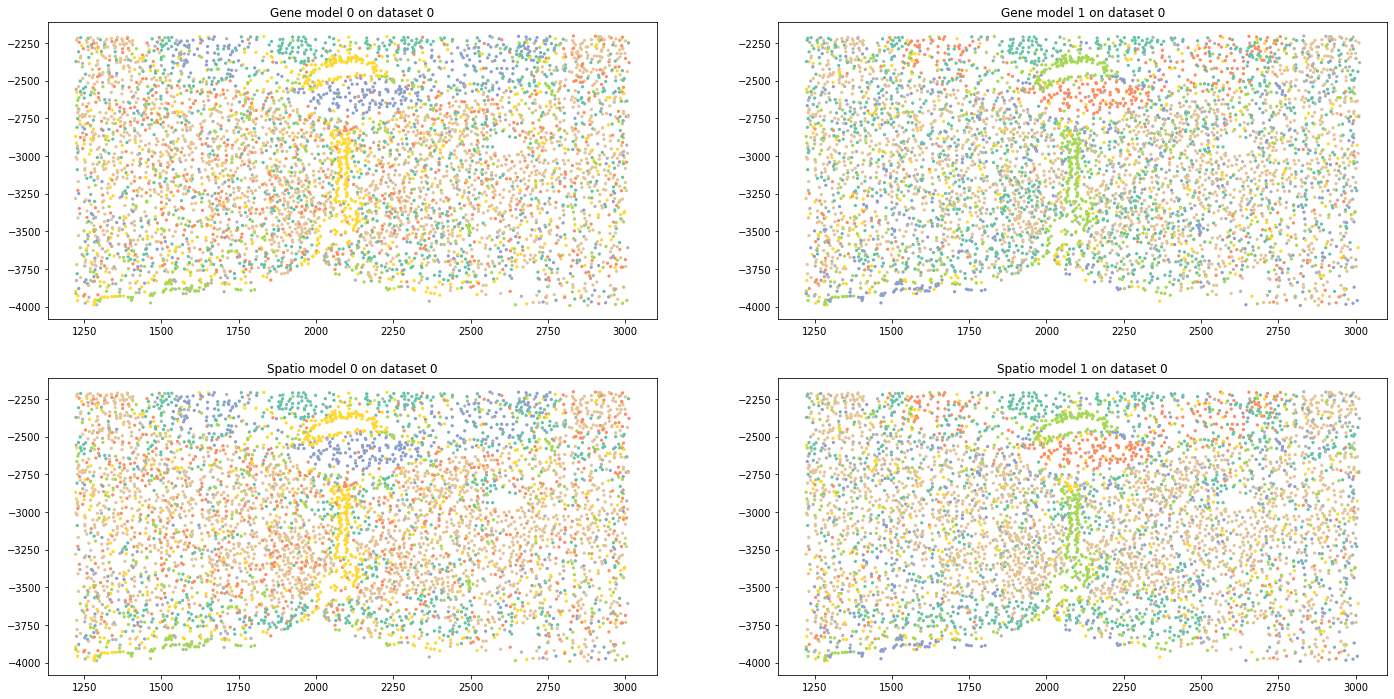

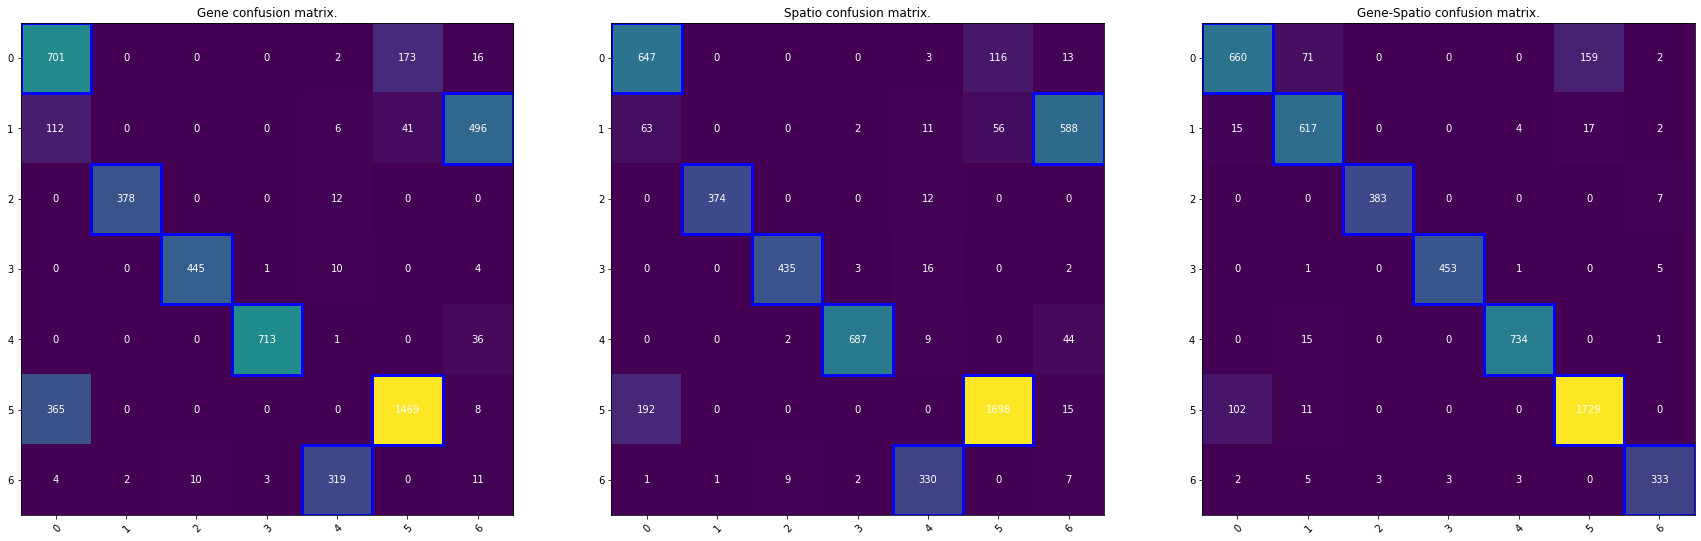

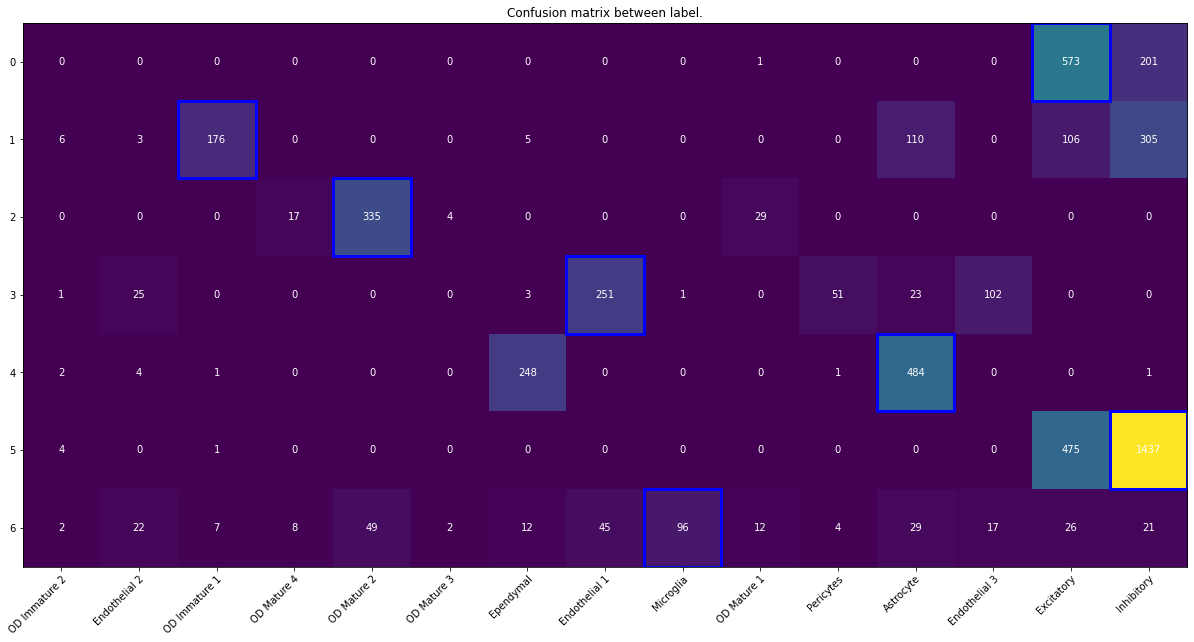

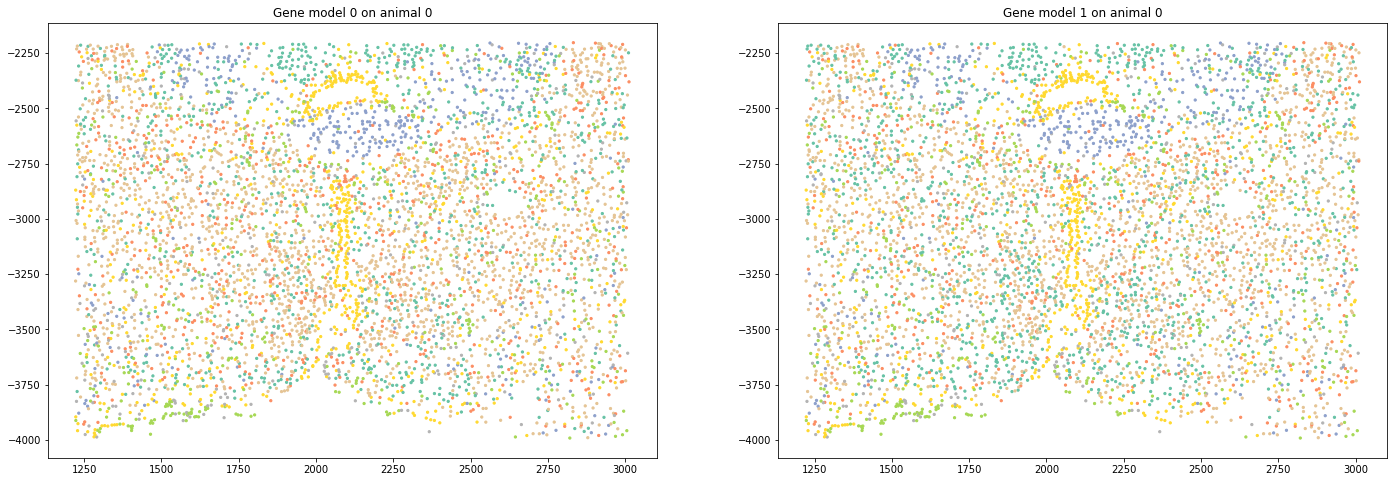

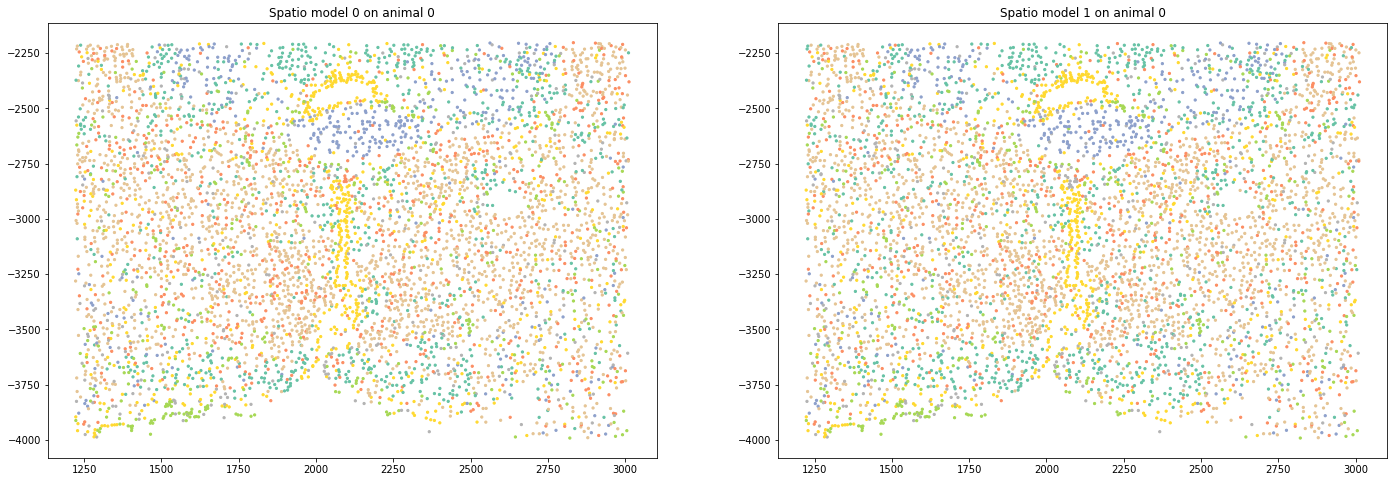

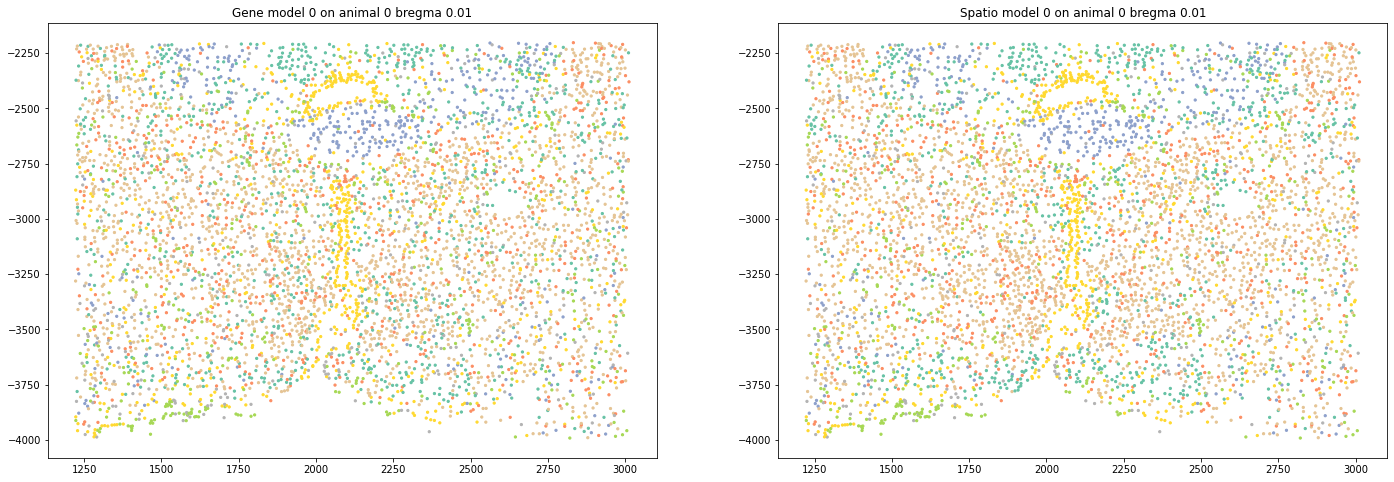

In [6]:
from fict.utils import data_op as dop
plt.close('all')
save_f = "/home/heavens/CMU/FISH_Clustering/Report/Figure"
base_f = "/home/heavens/twilight/data/MERFISH_data/animal_multi2"
model_f = os.path.join(base_f,'trained_models.bn')
cv_f = os.path.join(base_f,'cv_result.bn')
loader_f = os.path.join(base_f,'loaders.bn')
field = 0.01
animal1 = 0
animal2 = 1
models = load(model_f)
e_gene,e_spatio,cv_gene,cv_spatio = load(cv_f)
animal_n = e_gene.shape[0]
cv_all_gene = {}
cv_all_spatio = {}
for i in np.arange(animal_n):
 for j in np.arange(animal_n):
  if i==j:
      continue
  for k in np.arange(animal_n):    
      pg_i = np.argmax(e_gene[k,i,1],axis = 0)
      pg_j = np.argmax(e_gene[k,j,1],axis = 0)
      cv_all_gene[(i,j,k)] = adjusted_rand_score(pg_i,pg_j)
      ps_i = np.argmax(e_spatio[k,i,1],axis = 0)
      ps_j = np.argmax(e_spatio[k,j,1],axis = 0)
      cv_all_spatio[(i,j,k)] = adjusted_rand_score(ps_i,ps_j)


loaders = load(loader_f)
label,tag = dop.one_hot_vector(np.asarray(loaders[animal1].cell_labels))
label = np.transpose(label)
figs,axs = compare_visual(e_gene,e_spatio,loaders,animal1,animal2,field = field,mode = 'coordinate')
field_mask = loaders[animal1].field==field
field_mask = field_mask[:,0]
cm_gene = confusion_matrix(e_gene[animal1,animal2,0],
                      e_gene[animal1,animal2,1],
                      field_mask)
cm_sp = confusion_matrix(e_spatio[animal1,animal2,0],
                         e_spatio[animal1,animal2,1],
                         field_mask)
cm_gs = confusion_matrix(e_gene[animal1,animal2,0],
                         e_spatio[animal1,animal2,0],
                         field_mask)
e_spatio_coarse = e_spatio[animal1,animal1,0]
cm_label = confusion_matrix(e_spatio_coarse,label,field_mask)

fig,axs = plt.subplots(ncols = 3, nrows = 1,figsize=(30,10))
fig2,axs2 = plt.subplots(ncols = 1, nrows = 1,figsize=(30,10))
perm_gene,overlap_gene = greedy_match(cm_gene)
perm_spatio,overlap_spatio = greedy_match(cm_sp)
perm_gs,overlap_gs = greedy_match(cm_gs)
perm_label,overlap_label = greedy_match(cm_label)
heatmap(cm_gene,
        axs[0],
        title = 'Gene confusion matrix.',
        highlight_cells = list(zip(perm_gene,np.arange(len(perm_gene)))))
heatmap(cm_sp,
        axs[1],
        title = "Spatio confusion matrix.",
        highlight_cells = list(zip(perm_spatio,np.arange(len(perm_spatio)))))
heatmap(cm_gs,
        axs[2],
        title = "Gene-Spatio confusion matrix.",
        highlight_cells = list(zip(perm_gs,np.arange(len(perm_gs)))))
heatmap(cm_label,
        axs2,
        xticks = tag,
        title = 'Confusion matrix between label.',
        highlight_cells = list(zip(perm_label,np.arange(len(perm_label)))))
fig.savefig(os.path.join(save_f,"Confusion_Matrix"))
fig2.savefig(os.path.join(save_f,"Confusion_Matrix_label"))
fig_gene,axs_gene = cluster_plot(e_gene[animal1,animal2,0],
                                  e_gene[animal1,animal2,1],
                                  loaders[animal1],
                                  np.arange(len(perm_gene)),
                                  perm_gene,
                                  field = field,
                                  title = ['Gene model %d on animal %d'%(animal1,animal1),
                                           'Gene model %d on animal %d'%(animal2,animal1)])
fig_gene.savefig(os.path.join(save_f,"CrossValidationGene"))
fig_spatio,axs_spatio = cluster_plot(e_spatio[animal1,animal2,0],
                                     e_spatio[animal1,animal2,1],
                                     loaders[animal1],
                                     np.arange(len(perm_spatio)),
                                     perm_spatio,
                                     field = field,
                                     title = ['Spatio model %d on animal %d'%(animal1,animal1),
                                              'Spatio model %d on animal %d'%(animal2,animal1)])
fig_spatio.savefig(os.path.join(save_f,"CrossValidationSpatio"))
fig_gs,axs_gs = cluster_plot(e_gene[animal1,animal2,0],
                             e_spatio[animal1,animal2,0],
                             loaders[animal1],
                             np.arange(len(perm_gs)),
                             perm_gs,
                             field = field,
                             title = ['Gene model %d on animal %d bregma %.2f'%(animal1,animal1,field),
                                      'Spatio model %d on animal %d bregma %.2f'%(animal1,animal1,field)])
fig_gs.savefig(os.path.join(save_f,"Spatio-Gene_model_comparison"))

## Cluster assignment comparison between 7-class and 20-class model.

[ 9 16 19]
[ 7 11]
[ 1 15]
[3 6 8]
[ 2  4 14]
[ 0 10 13 17 18]
[ 5 12]


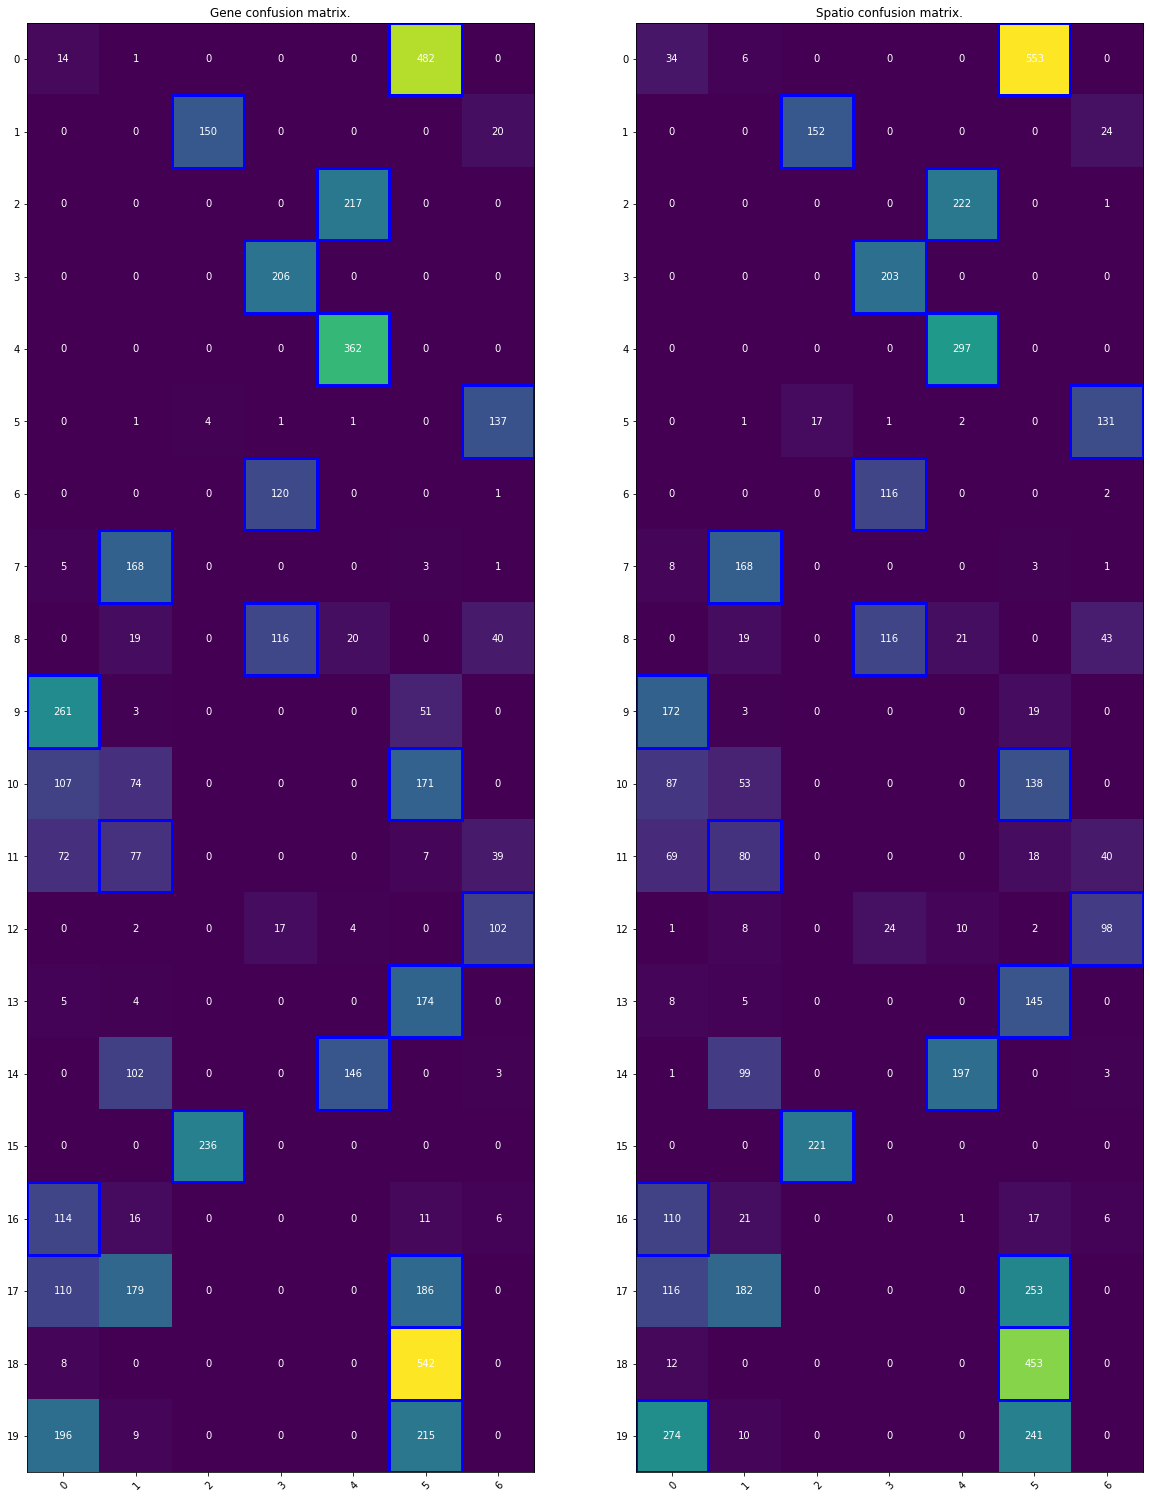

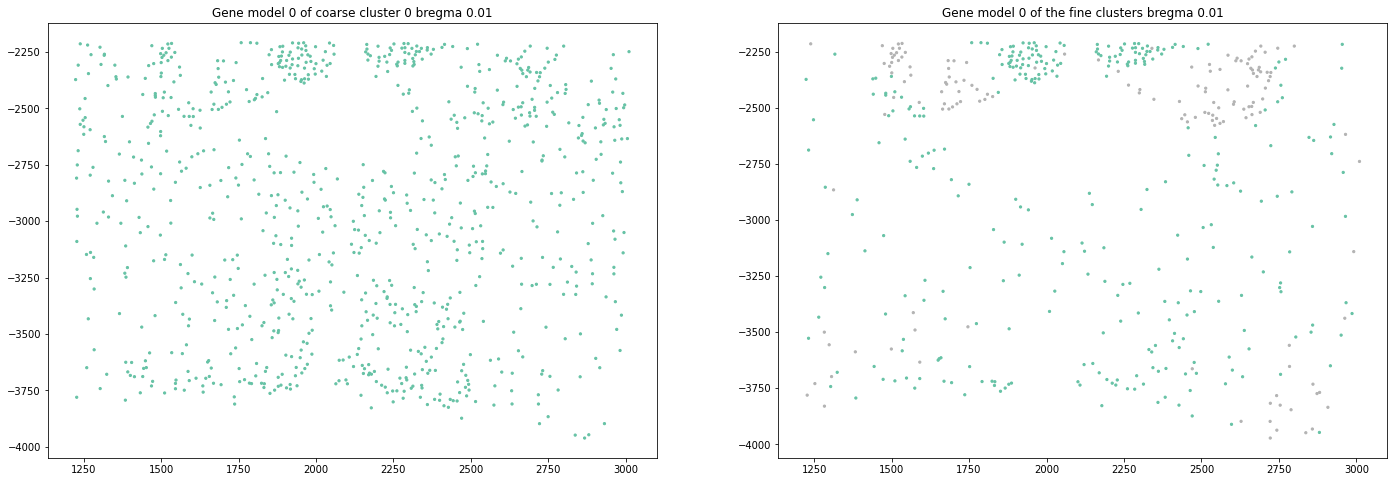

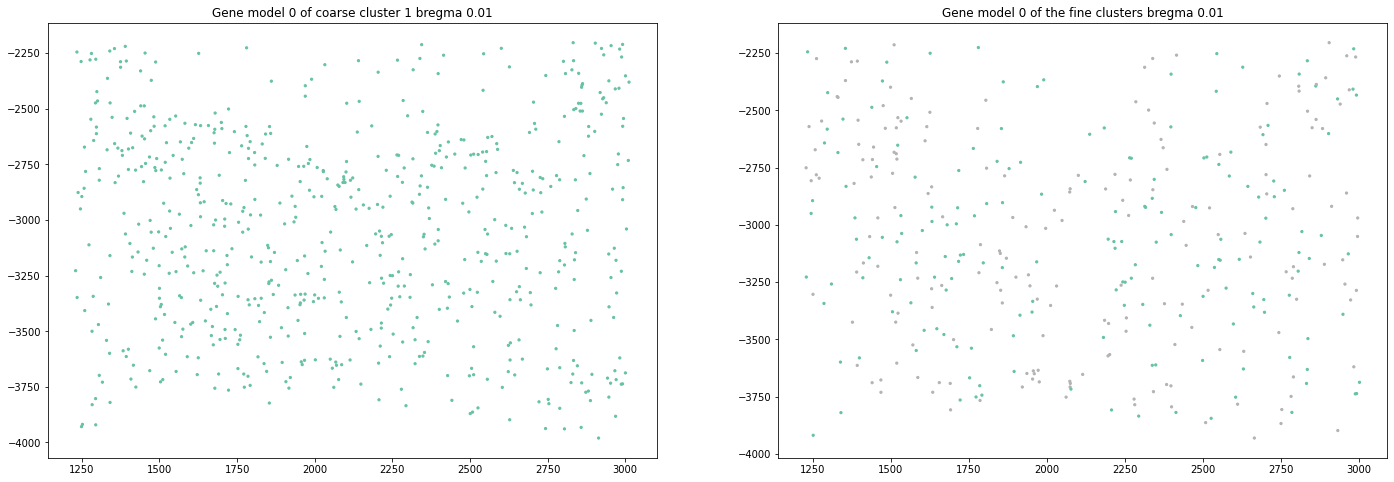

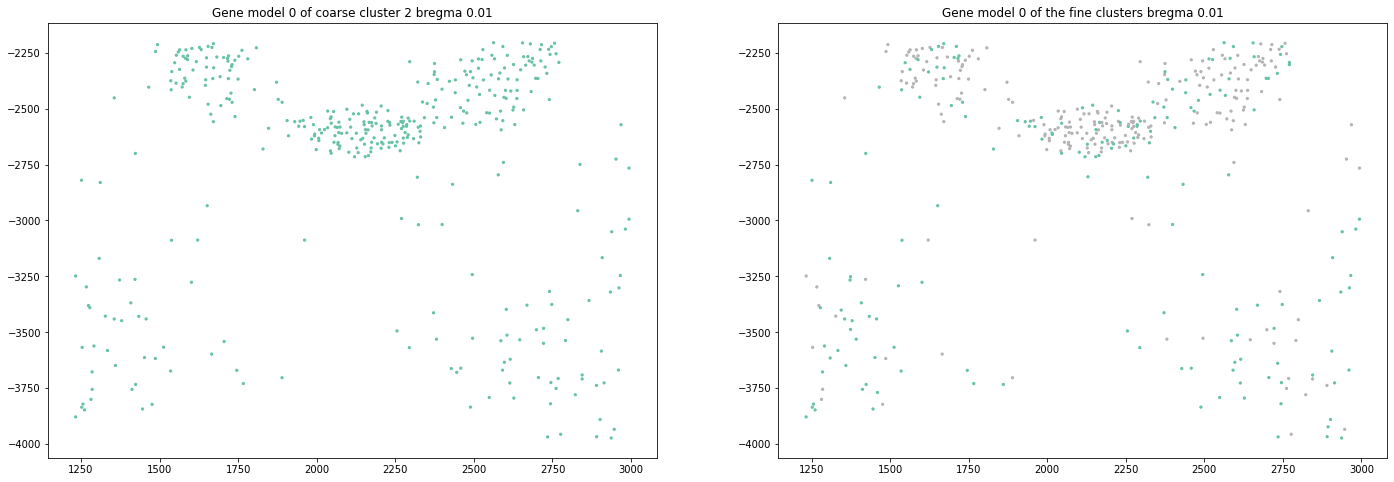

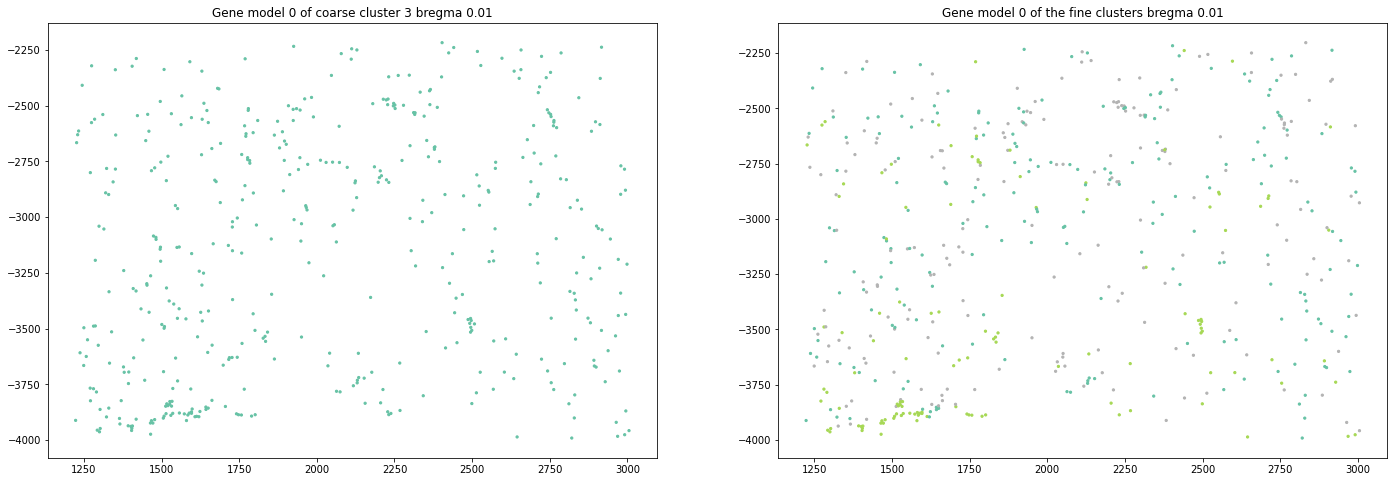

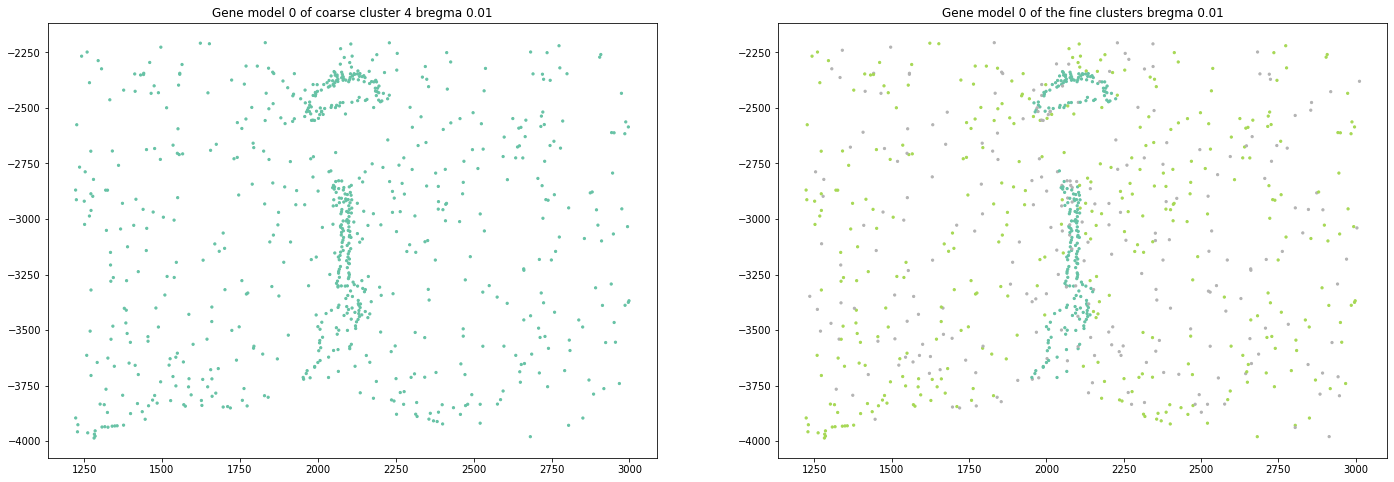

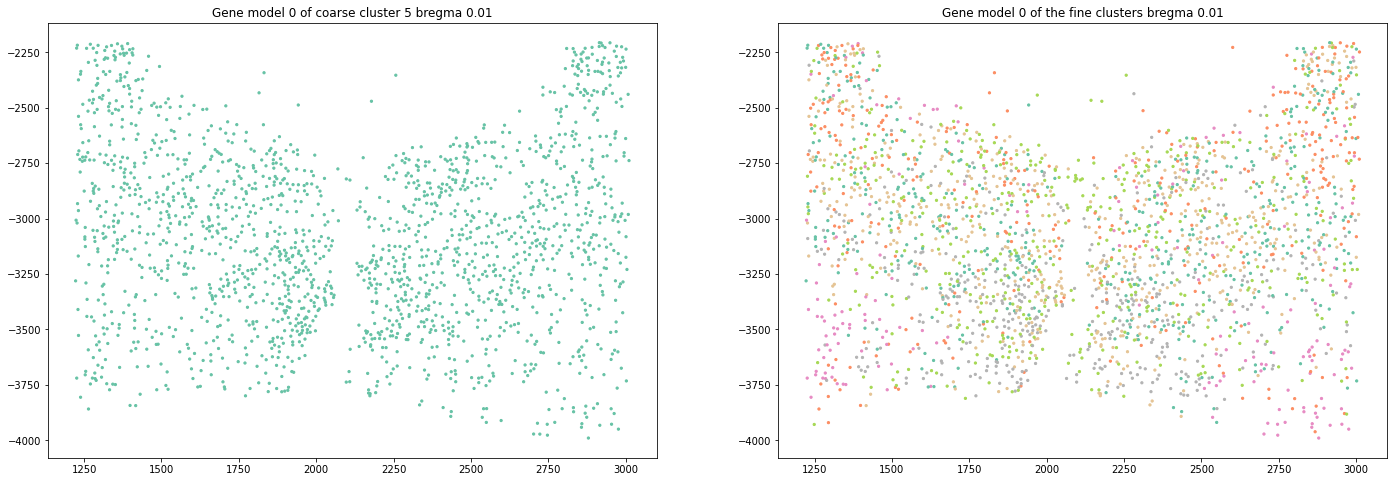

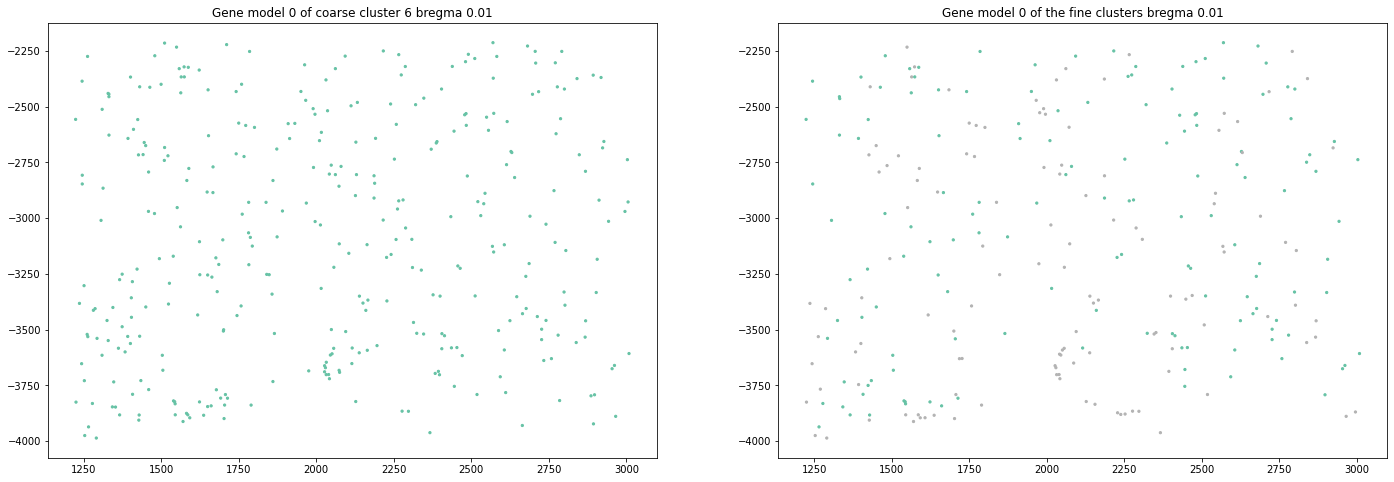

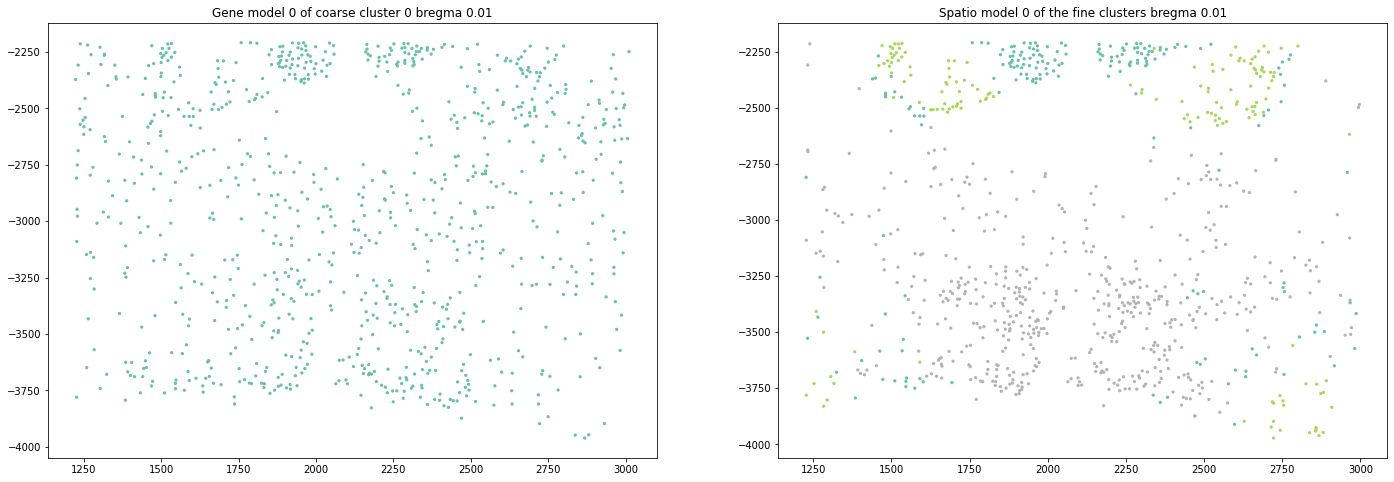

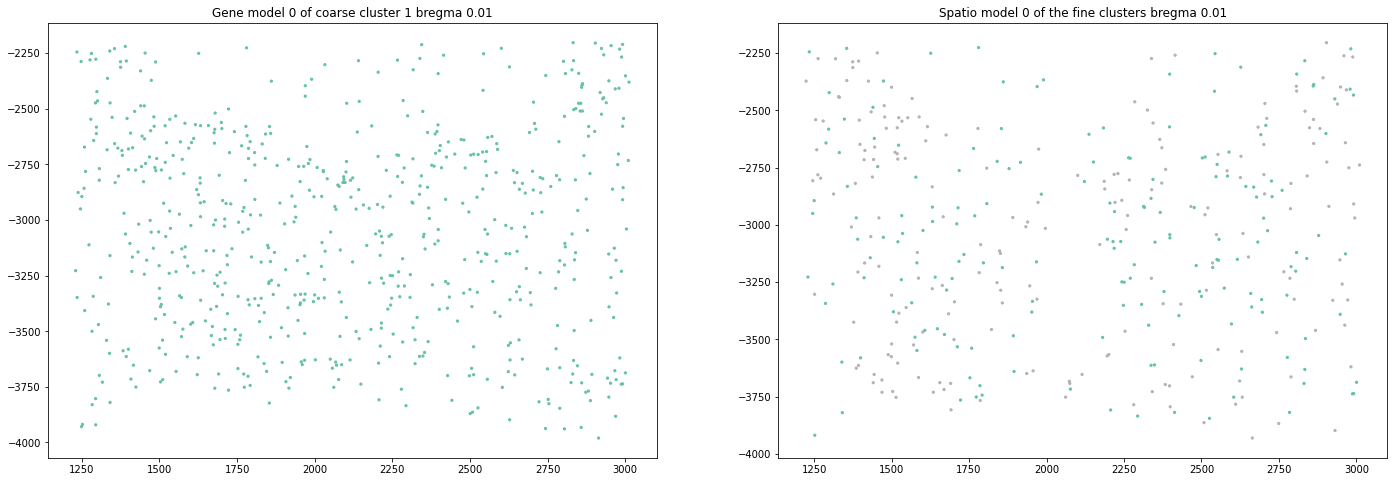

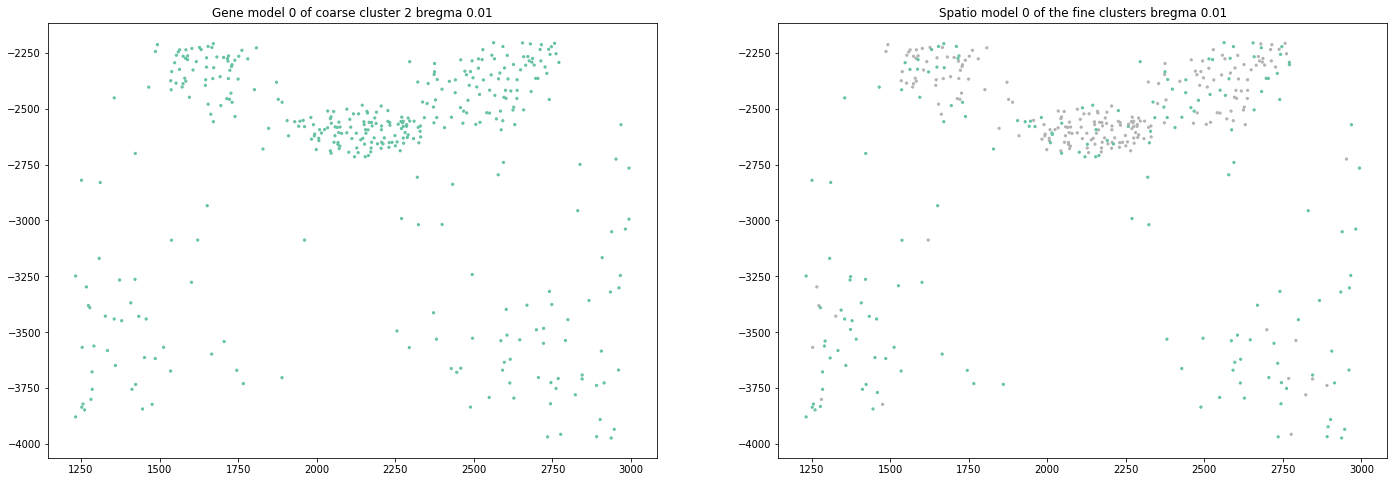

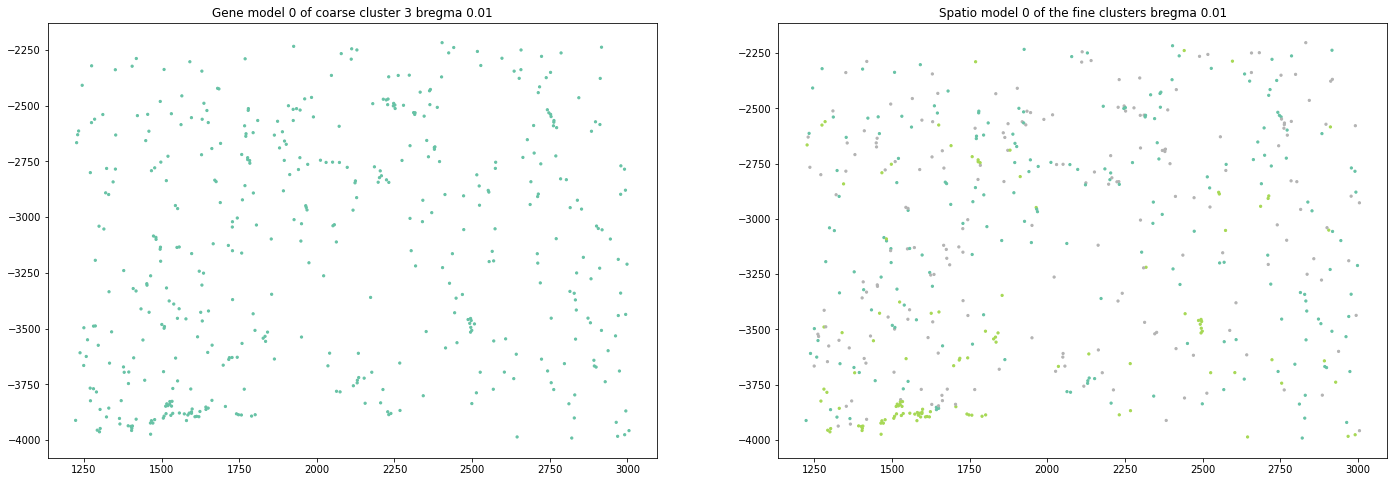

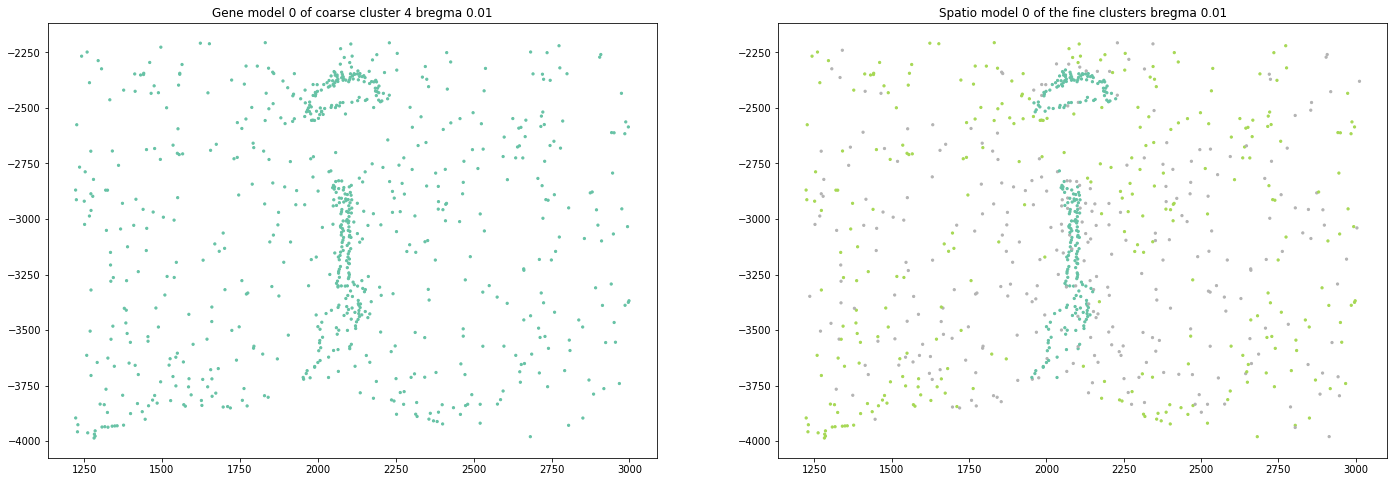

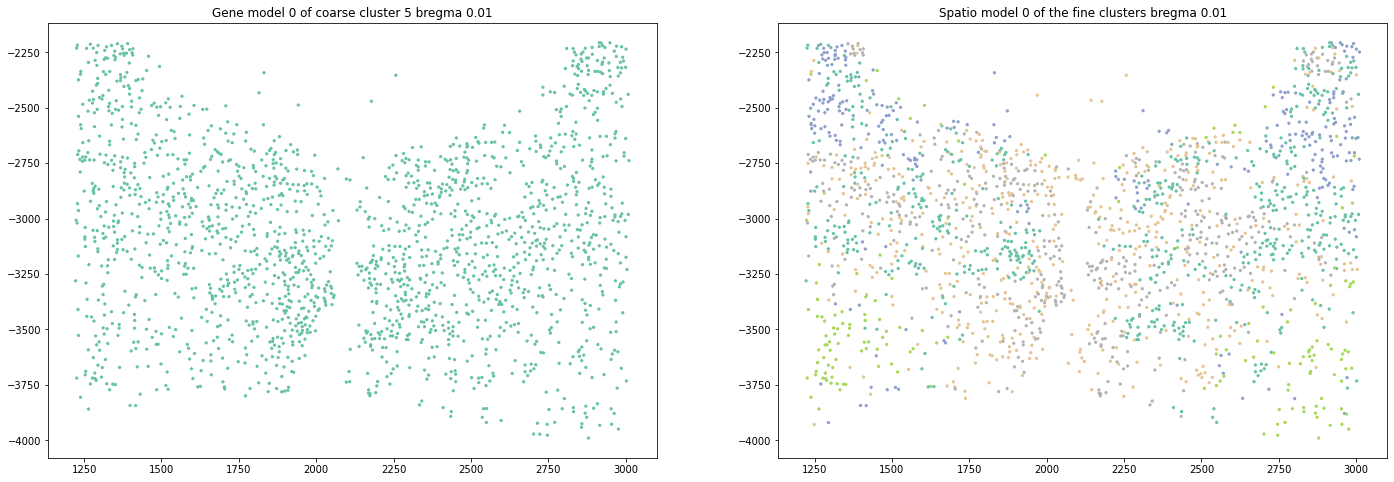

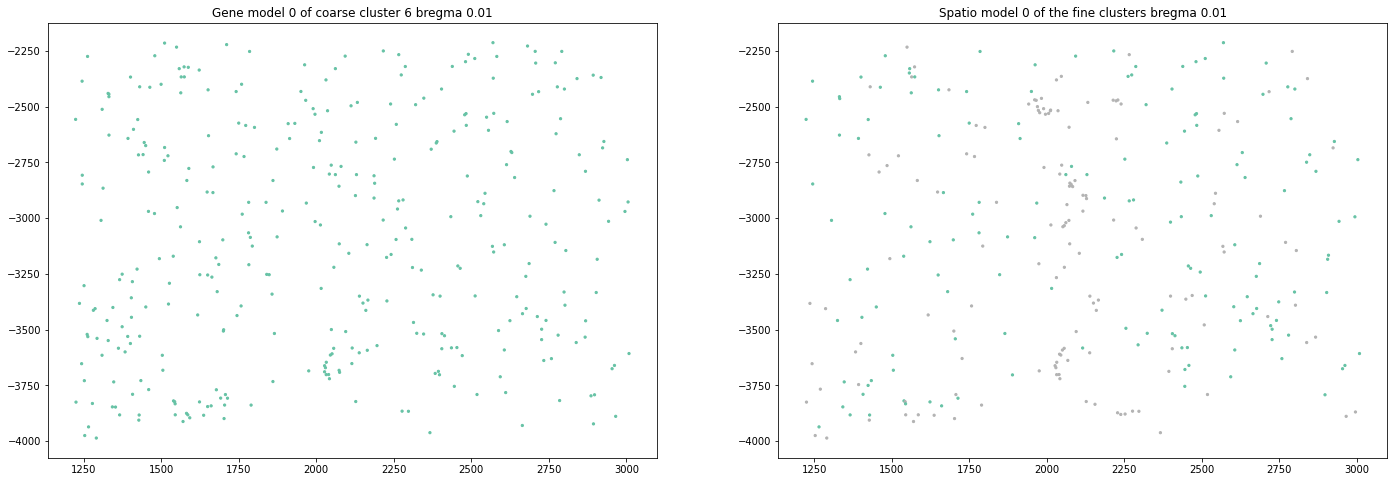

In [7]:
plt.close('all')
base7_f = "/home/heavens/twilight/data/MERFISH_data/animal_multi2"
model7_f = os.path.join(base7_f,'trained_models.bn')
cv7_f = os.path.join(base7_f,'cv_result.bn')
loader7_f = os.path.join(base7_f,'loaders.bn')
base20_f = "/home/heavens/twilight/data/MERFISH_data/animal_multi4_20class"
model20_f = os.path.join(base20_f,'trained_models.bn')
cv20_f = os.path.join(base20_f,'cv_result.bn')
loader20_f = os.path.join(base20_f,'loaders.bn')
loader7 = load(loader7_f)
loader20 = load(loader20_f)
model_7 = load(model7_f)
model_20 = load(model20_f)
animal_id = 0
field = 0.01
field_mask = loader7[animal_id].field==field
field_mask = field_mask[:,0]
e_gene7,e_spatio7,cv_gene7,cv_spatio7 = load(cv7_f)
e_gene20,e_spatio20,cv_gene20,cv_spatio20 = load(cv20_f)
e_gene_coarse = e_gene7[animal_id,animal_id,0]
e_spatio_coarse = e_spatio7[animal_id,animal_id,0]
e_gene_fine = e_gene20[animal_id,animal_id,0]
e_spatio_fine = e_spatio20[animal_id,animal_id,0]
cm_gene = confusion_matrix(e_gene_fine,
                           e_gene_coarse,
                           field_mask)
cm_spatio = confusion_matrix(e_spatio_fine,
                             e_gene_coarse,
                             field_mask)
fig,axs = plt.subplots(ncols = 2, nrows = 1,figsize = (20,30))
perm_gene,overlap_gene = greedy_match(cm_gene,bijection = False)
perm_spatio,overlap_spatio = greedy_match(cm_spatio,bijection = False)

heatmap(cm_gene,
        axs[0],
        title = 'Gene confusion matrix.',
        highlight_cells = list(zip(perm_gene,np.arange(len(perm_gene)))))
heatmap(cm_spatio,
        axs[1],
        title = "Spatio confusion matrix.",
        highlight_cells = list(zip(perm_spatio,np.arange(len(perm_spatio)))))
fine_cluster_n = e_spatio_fine.shape[0]
for cluster_id in np.arange(7):
    fine_cluster = np.arange(fine_cluster_n)
    fine_cluster_ids = fine_cluster[perm_gene == cluster_id]
    cluster_plot(e_gene_coarse,
                 e_gene_fine,
                 loader7[animal_id],
                 np.asarray([cluster_id]),
                 fine_cluster_ids,
                 field = field,
                 title = ['Gene model %d of coarse cluster %d bregma %.2f'%(animal_id,cluster_id,field),'Gene model %d of the fine clusters bregma %.2f'%(animal_id,field)])

for cluster_id in np.arange(7):
    fine_cluster = np.arange(fine_cluster_n)
    fine_cluster_ids = fine_cluster[perm_spatio == cluster_id]
    print(fine_cluster_ids)
    cluster_plot(e_gene_coarse,
                 e_spatio_fine,
                 loader7[animal_id],
                 np.asarray([cluster_id]),
                 fine_cluster_ids,
                 field = field,
                 title = ['Gene model %d of coarse cluster %d bregma %.2f'%(animal_id,cluster_id,field),'Spatio model %d of the fine clusters bregma %.2f'%(animal_id,field)])



In [8]:
def select_by_cluster(loader,expectation,ids,field = None):
    predict = np.argmax(expectation,axis = 0)
    locs = loader.coordinate
    mask = predict == ids[0]
    for i in ids:
        mask = np.logical_or(mask,predict == i)
    if field is not None:
        field_mask = loader.field==field
        field_mask = field_mask[:,0]
        mask = np.logical_and(mask,field_mask)
    locs = locs[mask,:]
    predict = predict[mask]
    return locs,predict
    
def side_plot(e_coarse,
              e_fine,
              main_id,
              side_id,
              fine_ids,
              loader,
              field = None,
              main_tag = 'Unknown',
              side_tag = 'Unknown'):
    if type(main_id) is np.int_ or type(main_id) is int:
        main_id = np.asarray([main_id])
    if type(side_id) is np.int_ or type(side_id) is int:
        side_id = np.asarray([side_id])
    locs_coarse,p_coarse = select_by_cluster(loader,e_coarse,main_id,field)
    locs_side,p_side = select_by_cluster(loader,e_coarse,side_id,field)
    locs_fine,p_fine = select_by_cluster(loader,e_fine,fine_ids,field)
    colors_coarse = cm.get_cmap('cool',len(fine_ids))
    colors_side = "grey"
    colors_fine = cm.get_cmap('cool',len(fine_ids))
    c_fine = np.copy(p_fine)
    for idx,p in enumerate(fine_ids):
        c_fine[c_fine==p] = idx
    figs,axs = plt.subplots(nrows = 1,ncols = 1)
    figs.set_size_inches(12,h=8)
    scatter_main = axs.scatter(locs_fine[:,0],
                   locs_fine[:,1],
                   c=c_fine,
                   cmap = colors_fine,
                   s=20)
    scatter_side = axs.scatter(locs_side[:,0],
                   locs_side[:,1],
                   c=colors_side,
                   marker = '^',
                   s=20,
                   label = side_tag)    
    return figs,axs,scatter_main,scatter_side


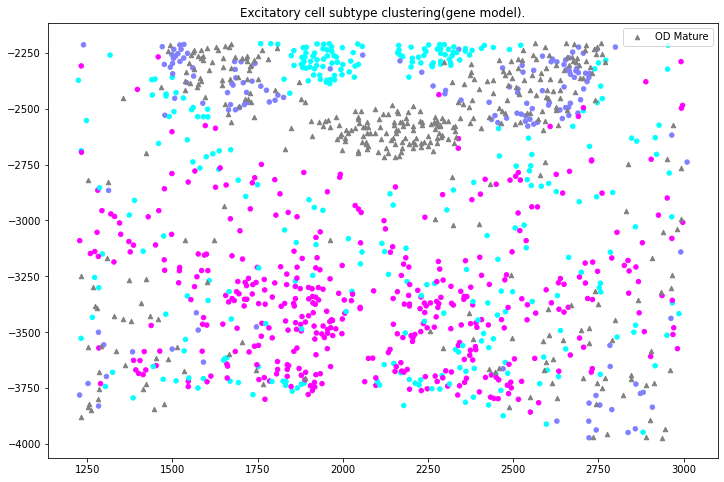

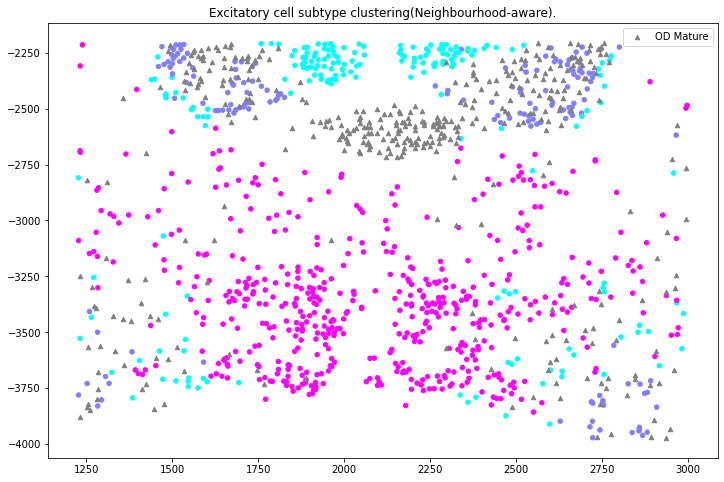

In [9]:
main_cluster = 0
side_cluster = 2
fine_clusters = np.arange(fine_cluster_n)
fine_clusters = fine_clusters[perm_spatio == main_cluster]
cell_tag = np.asarray(tag)
cell_tag = cell_tag[perm_label]
fig,axs_gene,gene_main_sc,gene_side_sc = side_plot(e_gene_coarse,
                                               e_gene_fine,
                                               main_cluster,
                                               side_cluster,
                                               fine_clusters,
                                               loader7[animal_id],
                                               field = 0.01,
                                               main_tag = cell_tag[main_cluster],
                                               side_tag = 'OD Mature')
axs_gene.legend(loc = "upper right",fontsize = 10)
axs_gene.set_title("%s cell subtype clustering(gene model)."%(cell_tag[main_cluster]))
fig.savefig(os.path.join(save_f,"ExSub_type_Gene"))
fig,axs_spatio,spatio_main_sc,spatio_side_sc = side_plot(e_spatio_coarse,
                                                     e_spatio_fine,
                                                     main_cluster,
                                                     side_cluster,
                                                     fine_clusters,
                                                     loader7[animal_id],
                                                     field = 0.01,
                                                     main_tag = cell_tag[main_cluster],
                                                     side_tag = 'OD Mature')
axs_spatio.set_title("%s cell subtype clustering(Neighbourhood-aware)."%(cell_tag[main_cluster]))
axs_spatio.legend(loc = "upper right",fontsize = 10)
fig.savefig(os.path.join(save_f,"ExSub_type_Spatio"))

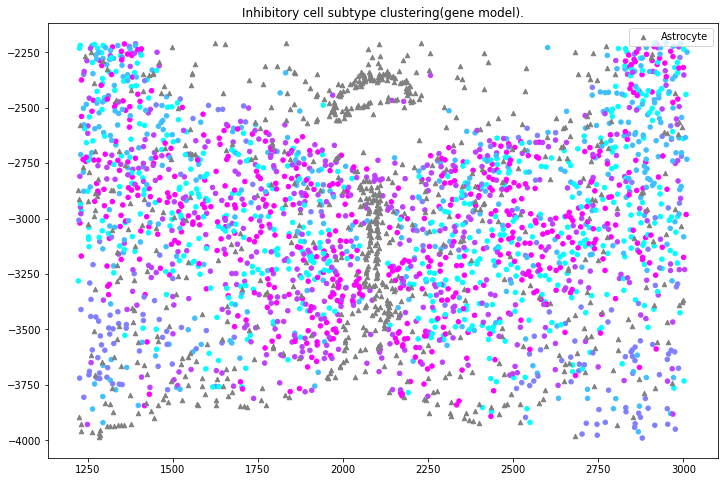

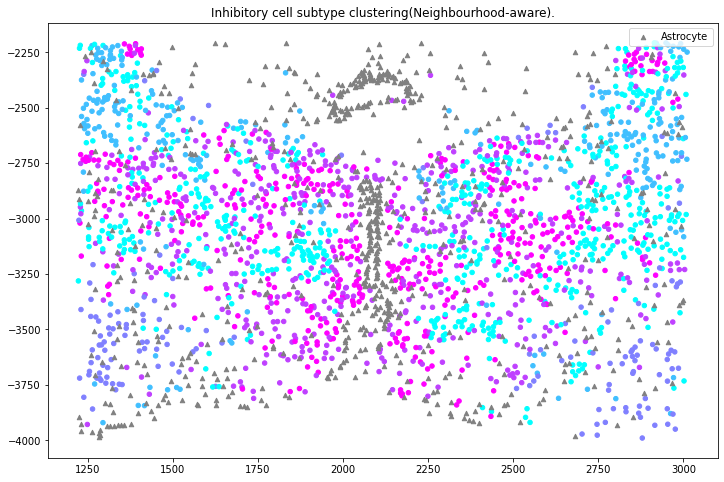

In [17]:
main_cluster = 5
side_cluster = 4
fine_clusters = np.arange(fine_cluster_n)
fine_clusters = fine_clusters[perm_spatio == main_cluster]
cell_tag = np.asarray(tag)
cell_tag = cell_tag[perm_label]
fig,axs_gene,gene_main_sc,gene_side_sc = side_plot(e_gene_coarse,
                                               e_gene_fine,
                                               main_cluster,
                                               side_cluster,
                                               fine_clusters,
                                               loader7[animal_id],
                                               field = 0.01,
                                               main_tag = cell_tag[main_cluster],
                                               side_tag = cell_tag[side_cluster])
axs_gene.legend(loc = "upper right",fontsize = 10)
axs_gene.set_title("%s cell subtype clustering(gene model)."%(cell_tag[main_cluster]))
fig.savefig(os.path.join(save_f,"InSub_type_Gene"))
fig,axs_spatio,spatio_main_sc,spatio_side_sc = side_plot(e_spatio_coarse,
                                                     e_spatio_fine,
                                                     main_cluster,
                                                     side_cluster,
                                                     fine_clusters,
                                                     loader7[animal_id],
                                                     field = 0.01,
                                                     main_tag = cell_tag[main_cluster],
                                                     side_tag = cell_tag[side_cluster])
axs_spatio.set_title("%s cell subtype clustering(Neighbourhood-aware)."%(cell_tag[main_cluster]))
axs_spatio.legend(loc = "upper right",fontsize = 10)
fig.savefig(os.path.join(save_f,"InSub_type_Spatio"))

In [19]:
perm_label

array([13,  2,  4,  7, 11, 14,  8])

### Zoomed in plot

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
def zoomed_inset_plot(e1,e2,loader,cell1,cell2,zoom_region,field = None,title = ['','']):
    """Args:
    e1: The first expectation.
    e2: The second expectation.
    loader: The data loader of e1 and e2.
    cell1: The order of cluster of e1.
    cell2: The order of cluster of e2.
    zoom_region: The region to zoomed in, format [x_bot,x_top,y_left,y_right]
    field: The slice that used to plot.
    title: The title of two plots.
    
    """
    predict1 = np.argmax(e1,axis = 0)
    predict2 = np.argmax(e2,axis = 0)
    if type(cell1) is np.int_ or type(cell1) is int:
        cell1 = np.asarray([cell1])
    if type(cell2) is np.int_ or type(cell2) is int:
        cell2 = np.asarray([cell2])
    assert len(cell1)==len(cell2)
    mask1 = predict1 == cell1[0]
    mask2 = predict2 == cell2[0]
    for idx,c in enumerate(cell1):
        mask1 = np.logical_or(mask1,predict1 == c)
        mask2 = np.logical_or(mask2,predict2 == cell2[idx])
    if field is not None:
        field_mask = loader.field==field
        field_mask = field_mask[:,0]
        mask1 = np.logical_and(mask1,field_mask)
        mask2 = np.logical_and(mask2,field_mask)
    locs = loader.coordinate
    locs1 = locs[mask1,:]
    locs2 = locs[mask2,:]
    masked_locs = [locs1,locs2]
    figs,axs = plt.subplots(nrows = 1,ncols = 2)
    figs.set_size_inches(24,h=8)
    predict1 = predict1[mask1]
    predict2 = predict2[mask2]
    p1 = np.copy(predict1)
    p2 = np.copy(predict2)
    ps = [p1,p2]
    colors = cm.get_cmap('Set2', len(cell1))
    for idx,c in enumerate(cell1):
        p1[predict1==c] = idx
    for idx,c in enumerate(cell2):
        p2[predict2==c] = idx
    axs[0].scatter(locs1[:,0],
                   locs1[:,1],
                   c=p1,
                   cmap = colors,
                   s=5)
    axs[0].set_title(title[0])
    axs[1].scatter(locs2[:,0],
                   locs2[:,1],
                   c=p2,
                   cmap = colors,
                   s=5)
    axs[1].set_title(title[1])
    for ax_i,ax in enumerate(axs):
        #Begin zoomed-in plot
        axins = zoomed_inset_axes(ax, 6, loc=1) # zoom = 6
        axins.scatter(masked_locs[ax_i][:,0],
                      masked_locs[ax_i][:,1],
                      c=ps[ax_i],
                      cmap = colors,
                      s=30)
        axins.set_xlim(zoom_region[0],zoom_region[1])
        axins.set_ylim(zoom_region[2],zoom_region[3])
        plt.yticks(visible = False)
        plt.xticks(visible = False)
        mark_inset(ax,axins,loc1 = 2,loc2 = 4,fc = "none",ec = "0.5")
    return figs,axs
fig,axs = zoomed_inset_plot(e_gene[animal1,animal2,0],
                            e_spatio[animal1,animal2,0],
                            loaders[animal1],
                            np.arange(len(perm_gs)),
                            perm_gs,
                            zoom_region = [2050,2120,-3200,-3050],
                            field = field,
                            title = ["Zoomed in plot Gene.",
                                     "Zoomed in plot Gene+Spatio."])
fig.savefig(os.path.join(save_f,"Zoomed_In"))

In [ ]:
cell_tag